<table style="width: 100%">
    <tr style="background: #ffffff">
        <td style="padding-top:25px; width: 180px">
            <img src="https://mci.edu/templates/mci/images/logo.svg" alt="Logo">
        </td>
        <td style="width: 100%">
            <div style="width: 100%; text-align:right"><font style="font-size:38px"><b>Softwaredesign</b></font></div>
            <div style="padding-top:0px; width: 100%; text-align:right"><font size="4"><b>WS 2023</b></font></div>
        </td>
    </tr>
</table>

---

<!-- LaTeX preamble -->
$$\newcommand{\mat}[1]{\boldsymbol{#1}}$$

# 01_07_Python Grundlagen - Polynomiale Regression zur Datenanalyse

Basierend auf dem Gründgerüst der letzen Hausübungen, soll nun eine weitere abgeleitete Klasse `PolynomialFitProcessor` erstellt werden, die eine polynomiale Regression durchführt.
Diese soll dabei von `DataProcessor` erben und wie gehbat die `process()` Methode überschreiben. Abhängig vom übergebenen `order` Parameter soll ein Polynom eben jenen Grades berechnet werden, das die Daten bestmöglich beschreibt. Die Koeffizienten des Polynoms sollen als `numpy array` im Attribut `p` gespeichert werden.  
Der Rückgabewerte der `process()` Methode soll ein neues `DataContainer` Objekt sein, das die ursprünglichen X-Werte enthält, sowie die berechneten Werte des gefitteten Polynoms.

Dieser Aufbau der Klasse macht sie universell einsetzbar und erlaubt es dem Nutzer, die Polynomordnung zur Laufzeit zu bestimmen bzw. mit der selben Klasse unterschiedliche Polynome zu fitten.

Die resultierende Klassenhierarchie soll wie folgt aussehen:

![](https://mermaid.ink/img/pako:eNqtVNFOwjAU_ZWmT6DDD1gICRF9W0LEJ51ZrttlNm5tc9tBEPl3uwGD6mZCQl_a3p2ec3bvbbc8VRnykKcFGDMTkBOUsYxls2czsDAnlaIxitg2lsyN8Xj6bixBaieTfeSW6T1oUB-4VxKskEhD5m1vjuAcbaLBCaFFGgzbeJI42iQZDJmbT0FCfRbd9bh7RiqFhOJil4HvsrZzphGplZD5dIUEObZi2yOjkJathczUOjHiCy9JR082akrPwVwVG6lKAcWjsN0OFGUnPqnvgAg2TF_Dja10ga9OJGiJ3zx7T9Hi4a-rZaHAMioNXpT7PhcNnV-X6bxXtgR9fVn_KoxG35Pu_utEdndRJ7S73L-gbbM3R7wS_Iv0ssYDXrqvIDJ3_5sUxtx-YIkxD90yA_qMuft7h4PKqsVGpjy0VGHAK52BxcNzwcMlFMZFMRNWUXR4UOop4Brki1JHzO4Hxz2NGg?type=png)

<!-- 
classDiagram

class DataProcessor {
    <<Abstract>>
    + process(DataConatiner) DataConatiner*
    + get_parameter()*
    + __str__() str
    + __repr__() str
}

class DataProcessorTerminal {
    <<Abstract>>
    + process(DataConatiner, DataConatiner)*
}

class MovingAverageProcessor{
    + int window_size
    + process(DataConatiner) DataConatiner
    + get_parameter() int
}

class PolynomialFitProcessor{
    + int order
    + np.array p
    + process(DataConatiner) DataConatiner
    + get_parameter() tuple[int, np.array]
}

class RMSEProcessor{
    + float rmse
    + process(DataConatiner, DataConatiner)
    + get_parameter() float
}

class MAPEProcessor{
    + float mape
    + process(DataConatiner, DataConatiner)
    + get_parameter() float
}

DataProcessor --|> DataProcessorTerminal
DataProcessor --|> MovingAverageProcessor
DataProcessor --|> PolynomialFitProcessor
DataProcessorTerminal --|> RMSEProcessor
DataProcessorTerminal --|> MAPEProcessor
-->

Die Bibliothek `numpy` kann bereits über die Funktionen `np.polyfit()` und `np.polyval()` Polynome fitten und berechnen. Wir wollen aber unsere Kenntnisse der linearen Algebra auffrischen und gleichzeitig den Umgang mit Matrizen in `numpy` üben. Deshalb soll die Berechnung des Polynoms in der `PolynomialFitProcessor` Klasse selbst implementiert werden, und nicht auf die `numpy` Funktionen zurückgegriffen werden.

### Notwendige imports

In [118]:
import math
from typing import List, Tuple
from abc import ABC, abstractmethod

import numpy as np
import matplotlib.pyplot as plt

### Definition der `DataContainer` Klasse

Die Klasse ist ident zu jener aus der letzten Hausübung und wird später für das Testen der Funktionalität benötigt

In [119]:
class DataContainer():

    # Konstruktor der Klasse DataContainer
    def __init__(self, x_data: List[float] = [], y_data: List[float] = []) -> None:
        self.x_data = x_data
        self.y_data = y_data

        #Exception werfen wenn Daten nicht gleich lang
        if len(self.x_data) != len(self.y_data):
            raise ValueError("x_data and y_data must have the same length")
    
    def get_x_data(self) -> List[float]:
        return self.x_data
    
    def get_y_data(self) -> List[float]:
        return self.y_data

    def set_x_data(self, x_data: List[float]) -> None:
        self.x_data = x_data

    def set_y_data(self, y_data: List[float]) -> None:
        self.y_data = y_data

    def get_x_mean(self) -> float:
        return sum(self.x_data) / len(self.x_data)

    def get_y_mean(self) -> float:
        return sum(self.y_data) / len(self.y_data)

    # Methode um die Daten zu plotten --> wird in einer späteren Einheit behandelt
    def plot(self) -> None:
        plt.plot(self.x_data, self.y_data, marker="o")
        plt.xlabel('x')
        plt.ylabel('y')

        # Hack to get the name of the instance variable for plotting --> should not be used in practice
        plt.title([k for k,v in globals().items() if v is self][0])        

        plt.show()

### Definition der `DataContainerProcessor` und `DataProcessorTerminal` Klassen

Die Klassen sind abstract und sind nach oben angeführtem Klassendiagramm zu implementieren.

In [120]:
class DataProcessor(ABC):

    def __init__(self):
        pass
    
    @abstractmethod
    def process(self, dc: DataContainer) -> DataContainer:
        raise NotImplementedError("process method not implemented")

    @abstractmethod
    def get_parameter(self):
        raise NotImplementedError("get_parameter method not implemented")
    
    @abstractmethod
    def __str__(self):
        raise NotImplementedError("__str__ method not implemented")

    @abstractmethod
    def __repr__(self):
        raise NotImplementedError("__repr__ method not implemented")

class DataProcessorTerminal(DataProcessor):

    @abstractmethod
    def process(self, dc1: DataContainer, dc2: DataContainer) -> None:
        raise NotImplementedError("process method not implemented")

### Erklärung zum Polynomfit

Hier wird die Berechnung des Polynoms erklärt, das in der `PolynomialFitProcessor` Klasse implementiert werden soll.  
Zu Beginn soll daher ein lineares Modell, als einfachstes Polynom, betrachtet werden, welches wir auf die folgenden Daten anwenden wollen.

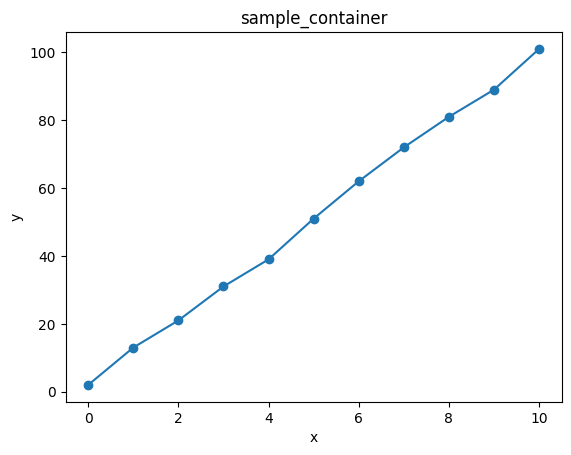

In [121]:
x = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
y = np.array([2, 13, 21, 31, 39, 51, 62, 72, 81, 89, 101])
sample_container = DataContainer(list[float](x), list[float](y))
sample_container.plot()

### Lineares Regressionsmodell
Für jedes $i$-te Messwertepaar $(x_i, y_i)$ wird angenommen, dass der Wert $y_i$ durch eine lineare Funktion von $x_i$ beschrieben wird:

$y_i = \beta_0 + \beta_1 x_i$

Dies kann effizient in Matrixschreibweise dargestellt werden:

$\vec{y} = \mat{X} \vec{\beta}$

wobei die Matrix $\mat{X} \in \R^{n \times 2}$ die Form

$\mat{X} = \begin{bmatrix} 1 & x_1 \\ 1 & x_2 \\ \vdots & \vdots \\ 1 & x_n \end{bmatrix}$

hat und der Vektor $\vec{\beta}  \in \R^{2 \times 1}$ die Form

$\vec{\beta} = \begin{bmatrix} \beta_0 \\ \beta_1 \end{bmatrix}$

besitzt.

Die Matrix $\mat{X}$ kann dabei direkt in `python`-Code erstellt werden.  
Um die Größe der Matrix vorzudefinieren, kann die Funktion `np.empty()` verwendet werden, die ein Tupel mit den Dimensionen der Matrix als Argument erwartet.  
Mit dem Slicing-Operator kann auf die einzelnen Zeilen/Spalten der Matrix zugegriffen werden, um diesen z.B.: Werte zuzuweisen.

In [122]:
n = len(x) #Anzahl der Datenpunkte

# Lösung einfügen
X = np.empty([n,2])
X[:, 0] = 1
X[:, 1] = np.arange(n)

# Lösung wird ausgegeben
print(f"X =\n{X}")

X =
[[ 1.  0.]
 [ 1.  1.]
 [ 1.  2.]
 [ 1.  3.]
 [ 1.  4.]
 [ 1.  5.]
 [ 1.  6.]
 [ 1.  7.]
 [ 1.  8.]
 [ 1.  9.]
 [ 1. 10.]]


Könnte die Matrix $\mat{X}$ invertiert werden (`np.linalg.inv()`), dann wäre eine direkte Lösung für $\vec{\beta}$ möglich.  
Da $\mat{X}$ jedoch nicht quadratisch ist, kann keine Inverse gefunden werden. Um den möglichen Lösungsweg zu beschreiben wird im Folgenden ein anderer Ansatz gewählt.

In [123]:
try:
    np.linalg.inv(X) # Wird zu einem Fehler führen, da die Matrix nicht invertierbar ist
except np.linalg.LinAlgError as e:
    #Fehler wird händisch abgefangen und ausgegeben, damit das Jupyter Notebook weiter läuft
    import traceback
    traceback.print_exc()

Traceback (most recent call last):
  File "C:\Users\Kevin\AppData\Local\Temp\ipykernel_41764\1979469471.py", line 2, in <module>
    np.linalg.inv(X) # Wird zu einem Fehler führen, da die Matrix nicht invertierbar ist
    ^^^^^^^^^^^^^^^^
  File "c:\dev\Python\.venv\Lib\site-packages\numpy\linalg\_linalg.py", line 609, in inv
    _assert_stacked_square(a)
  File "c:\dev\Python\.venv\Lib\site-packages\numpy\linalg\_linalg.py", line 202, in _assert_stacked_square
    raise LinAlgError('Last 2 dimensions of the array must be square')
numpy.linalg.LinAlgError: Last 2 dimensions of the array must be square


### Lösung im Sinne der Methode der kleinsten Fehlerquadrate

In der Realität folgen die Messwerte jedoch nicht exakt einer linearen Funktion, sondern weisen Messfehler auf. Daher wird ein Fehlerterm $\varepsilon_i$ hinzugefügt:

$y_i = \beta_0 + \beta_1 x_i + \varepsilon_i \quad$ bzw. $\quad \vec{y} = \mat{X} \vec{\beta} + \vec{\varepsilon}$

Das Bestimmen der Parameter $\vec{\beta}$ kann nun zu einem Optimierungsproblem umformuliert werden, bei dem die Fehler $\varepsilon_i$ minimiert werden sollen, denn es gilt:

$\vec{\varepsilon} = \vec{y} - \mat{X} \vec{\beta}$

Es stellt sich heruas, dass dies nun auch möglich ist, unabhängig davon, ob $\mat{X}$ direkt invertierbar ist oder nicht!

Um ein Minimum für $\vec{\varepsilon}$ zu finden muss eine geeignete Fehlerfunktion definiert werden. Üblicherweise wird die Methode der kleinsten Fehlerquadrate (least squares) verwendet, bei der die Summe der quadrierten Fehler minimiert wird:

$\min_{\vec{\beta}} \left\| \vec{\varepsilon} \right\|_2^2 = \min_{\vec{\beta}} \left\| \vec{y} - \mat{X} \vec{\beta} \right\|_2^2$

Wobei $\left\| \vec{v} \right\|_2 = \left( \sum_{i=1}^{n} v_i^2 \right)^{\frac{1}{2}}$ die euklidische Norm ("Länge eines Vektors") darstellt, welche quadriert als Fehlermaß genutzt wird.

Unter gewissen Voraussetzungen kann das Minimum analytisch bestimmt werden, wodurch es auch sehr leicht in Python implementiert werden kann.  
Es kann in weiterer Folge gezeigt werden, dass die optimale Lösung für $\vec{\beta}$ über den Ausdruck

$\vec{\beta} = \mat{H} \vec{y} = (\mat{X}^T \mat{X})^{-1} \mat{X}^T \vec{y}$

bestimmt werden kann.

Mit den `numpy`-Funktionen `np.linalg.inv()`, der Matrixmultiplikation mit dem `@`-Operator, und dem Transponieren einer Matrix durch das Attribute `X.T` kann dies sehr einfach implementiert werden.  
Anschließend kann das Polynom mit den berechneten Koeffizienten $\vec{\beta}$ berechnet werden.

In [124]:
#Lösung hier einfügen
H = np.linalg.inv(X.T @ X) @ X.T

# Lösung wird ausgegeben
print(f"{H.shape=}\n{H=}")

# Lösung hier einfügen
beta = H @ y

# Lösung wird ausgegeben
print(f"Fit parameter are {beta=}")

H.shape=(2, 11)
H=array([[ 3.18181818e-01,  2.72727273e-01,  2.27272727e-01,
         1.81818182e-01,  1.36363636e-01,  9.09090909e-02,
         4.54545455e-02, -1.38777878e-17, -4.54545455e-02,
        -9.09090909e-02, -1.36363636e-01],
       [-4.54545455e-02, -3.63636364e-02, -2.72727273e-02,
        -1.81818182e-02, -9.09090909e-03, -3.46944695e-18,
         9.09090909e-03,  1.81818182e-02,  2.72727273e-02,
         3.63636364e-02,  4.54545455e-02]])
Fit parameter are beta=array([1.81818182, 9.85454545])


Der hierbei entstehende Vektor $\vec{\beta}$ enthält die Koeffizienten des linearen Modells, so wie dieses ursprünglich aufgestellt wurde.

Weiters kann nun auch der Fehler $\varepsilon_i$ für jedes Messwertepaar berechnet werden. Dieser wird in der Regel als Residuum bezeichnet und kann durch die Differenz zwischen dem gemessenen Wert $y_i$ und dem vorhergesagten Wert $\hat{y}_i$ berechnet werden, wobei $\hat{y}_i = \beta_0 + \beta_1 x_i \Rightarrow \hat{\vec{y}} = \mat{X} \vec{\beta}$:

In [125]:
y_hat = X @ beta
epsilon = y - y_hat
print(f"{epsilon=}")

error_metric = np.linalg.norm(epsilon)**2
print(f"{error_metric=}")

epsilon=array([ 0.18181818,  1.32727273, -0.52727273, -0.38181818, -2.23636364,
       -0.09090909,  1.05454545,  1.2       ,  0.34545455, -1.50909091,
        0.63636364])
error_metric=np.float64(12.581818181818145)


Eine andere gängige Metrik zur Bewertung der Güte des Modells ist der RMSE (Root Mean Squared Error), der bereits in den vergangenen Hausübungen behandelt wurde.
Weiters kann auch das Bestimmtheitsmaß $R^2$ berechnet werden, um die Güte des Modells zu bewerten.

Dies soll aber an dieser Stelle nicht weiter diskutiert werden.

In [126]:
y_bar = np.mean(y)

R_squared = 1 - ((y - y_hat).T @ (y - y_hat)) / ((y - y_bar).T @ (y - y_bar))
print(f"{R_squared=}")

R_squared=np.float64(0.9988235694128047)


Die originalen Messdaten und das gefittete Polynom können nun in einem Plot dargestellt werden, um die Qualität des Fits visuell zu überprüfen.

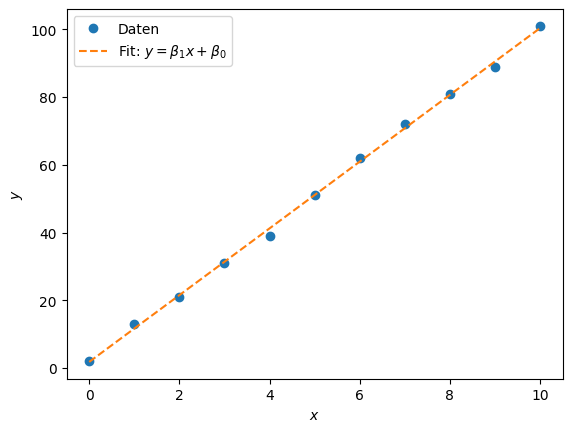

In [127]:
fig, ax = plt.subplots()
ax.plot(x, y, 'o', label="Daten")
ax.plot(x, beta[0] + beta[1] * x, '--', label="Fit: $y = \\beta_1 x + \\beta_0$")
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.legend()

## Erweitern auf das Fitten von Polynomen beliebigen Grades

Dieses Verfahren der linearen Regression kann auch auf Polynome beliebigen Grades erweitert werden. Für ein Polynom $m$-ten Grades gilt:

$y_i = \beta_0 + \beta_1 x_i + \beta_2 x_i^2 + \ldots + \beta_m x_i^m \quad$ bzw. in Matrixschreibweise $\quad \vec{y} = \mat{X} \vec{\beta}$

wobei sich die Matrix $\mat{X} \in \R^{n \times (m+1)}$ nun verändert auf

$\mat{X} = \begin{bmatrix} 1 & x_1 & x_1^2 & \ldots & x_1^m \\ 1 & x_2 & x_2^2 & \ldots & x_2^m \\ \vdots & \vdots & \vdots & \vdots & \vdots \\ 1 & x_n & x_n^2 & \ldots & x_n^m \end{bmatrix}$

und der Vektor $\vec{\beta}  \in \R^{(m+1) \times 1}$ zu

$\vec{\beta} = \begin{bmatrix} \beta_0 \\ \beta_1 \\ \beta_2 \\ \vdots \\ \beta_m \end{bmatrix}$

wird.

Die beste Lösung für $\vec{\beta}$ lässt sich jedoch weiterhin durch

$\vec{\beta} = \mat{H} \vec{y} = (\mat{X}^T \mat{X})^{-1} \mat{X}^T \vec{y}$

bestimmen, einzig die Matrix $\mat{X}$ ändert sich.

Um diesen Fall besser zu verstehen, soll ein Polynom 2. Grades auf die folgenden Daten angewendet werden, wobei $\vec{x}$ gleich bleibt und sich lediglich $\vec{y}$ ändert.

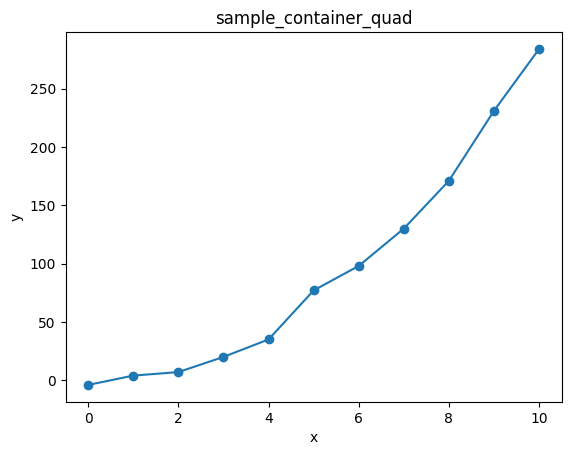

In [128]:
y_quad = np.array([-4, 4, 7, 20, 35, 77, 98, 130, 171, 231, 284])
sample_container_quad = DataContainer(list[float](x), list[float](y_quad))
sample_container_quad.plot()

Es kann nun die neue Matrix $\mat{X}$ erstellt werden und damit später die Koeffizienten $\vec{\beta}$ berechnen zu können.

In [129]:
order = 2 #1 for linear, 2 for quadratic, etc.

# Lösung hier einfügen
X = np.empty((n, order+1))
for i in range(0, order+1, 1):
    X[:,i] = np.power(np.arange(n), i)
#X[:,0] = 1
#X[:,1] = np.arange(n)
#X[:,2] = np.arange(n)**order

# Lösung wird ausgegeben
print(f"{X.shape=}\n{(X)}")

X.shape=(11, 3)
[[  1.   0.   0.]
 [  1.   1.   1.]
 [  1.   2.   4.]
 [  1.   3.   9.]
 [  1.   4.  16.]
 [  1.   5.  25.]
 [  1.   6.  36.]
 [  1.   7.  49.]
 [  1.   8.  64.]
 [  1.   9.  81.]
 [  1.  10. 100.]]


H.shape=(3, 11)
beta.shape=(3,)
beta=array([-1.38461538, -1.5041958 ,  2.98951049])


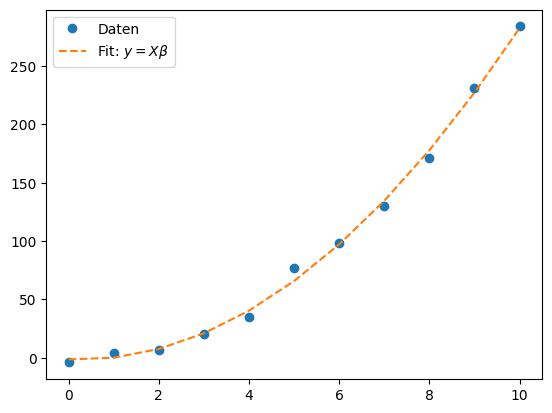

In [130]:
# Lösung hier einfügen
H = np.linalg.inv(X.T @ X) @ X.T

# Lösung wird ausgegeben
print(f"{H.shape=}")

# Lösung hier einfügen
beta = H @ y_quad

# Lösung wird ausgegeben
print(f"{beta.shape=}")
print(f"{beta=}")

# Lösung hier einfügen
y_quad_hat = X @ beta

# Lösung wird geplottet
fig, ax = plt.subplots()
ax.plot(x, y_quad, 'o', label="Daten")
ax.plot(x, y_quad_hat, '--', label="Fit: $y = X \\beta$")
ax.legend()

### Klassen zum Fitten von Polynomen beliebigen Grades

Es soll die Klasse `PolynomialFitProcessor` als Subklasse von `DataProcessor` implementiert werden.

In [131]:
class PolynomialFitProcessor(DataProcessor):

    def __init__(self, order: int):
        # Lösung hier einfügen
        self.order: int = order
        self.p = np.zeros(self.order+1)
    
    def process(self, dc: DataContainer) -> DataContainer:
        # Lösung hier einfügen
        n = len(dc.get_x_data())
        X = np.zeros((n, self.order+1))
        for i in range(0, self.order+1):
            X[:,i] = np.power(np.arange(n), i)
        H = np.linalg.inv(X.T @ X) @ X.T
        self.p = H @ dc.get_y_data()
        y_hat = list[float](X @ self.p)
        return DataContainer(dc.get_x_data(), y_hat)
    
    def get_parameter(self) -> tuple[int, np.ndarray]:
        # Lösung hier einfügen
        return (self.order, self.p)
    
    def __str__(self) -> str:
        # Lösung hier einfügen
        return F"A PolynomialFitProcessor of order{self.order} an the Coefficient {self.p}"
    
    def __repr__(self) -> str:
        # Lösung hier einfügen
        return F"PolynomialFitProcessor(order='{self.order}', p={self.p})"

An diesem Datensatz kann die Funktionalität der Klasse für lineare Polyonme getestet werden.
Dies beteutet das Objekt `processor` soll mit dem Parameter `order=1` initialisiert werden und die Methode `process()` aufgerufen werden.

(1, array([10.6,  9.6]))


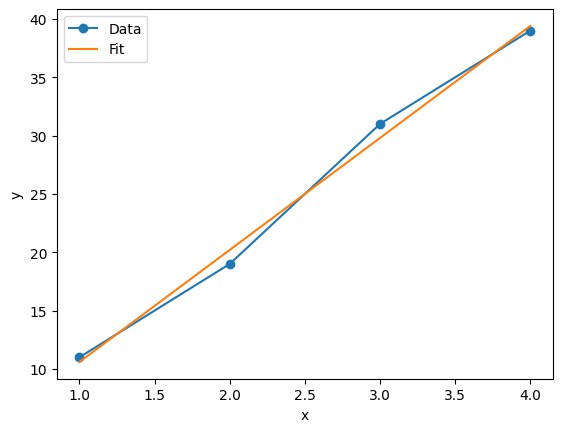

In [132]:
test = DataContainer([1, 2, 3, 4], [11, 19, 31, 39])

# Lösung hier einfügen
poly_proc = PolynomialFitProcessor(1)
test_fit = poly_proc.process(test)

# Lösung wird geplottet
print(poly_proc.get_parameter())
plt.plot(test.get_x_data(), test.get_y_data(), marker="o", label="Data")
plt.plot(test_fit.get_x_data(), test_fit.get_y_data(), label="Fit")
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

### Testen der Implementierung

Es ist ein `DataContainer`-Objekt gegeben, welches mit einer Instanz von `PolynomialFitProcessor` (mit `order = 2`) und `RMSEProcessor` verarbeitet werden soll.  
Als finales Ergebnis ist der Plot der gefitteten Daten und der RMSE-Wert zwischen originalen Daten und den gefitteten Daten von Interesse.

In [133]:
class RMSEProcessor(DataProcessorTerminal):

    def __init__(self):
        self.rmse = 0.0

    def process(self, dc1: DataContainer, dc2: DataContainer) -> None:
        targets = dc1.get_y_data()
        predictions = dc2.get_y_data()

        mse = sum([(p - t)**2 for p, t in zip(predictions, targets)]) / len(predictions)
        self.rmse = math.sqrt(mse)

    def get_parameter(self) -> float:
        return self.rmse
    
    def __str__(self) -> str:
        return f"RMSEProcessor with RMSE {self.rmse}"
    
    def __repr__(self) -> str:
        return self.__str__()

(2, array([ 0.58622088, -1.24910985,  0.34720255]))
0.7548878181256804


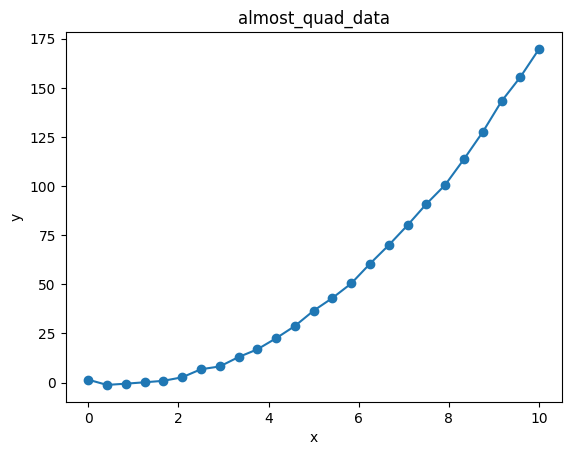

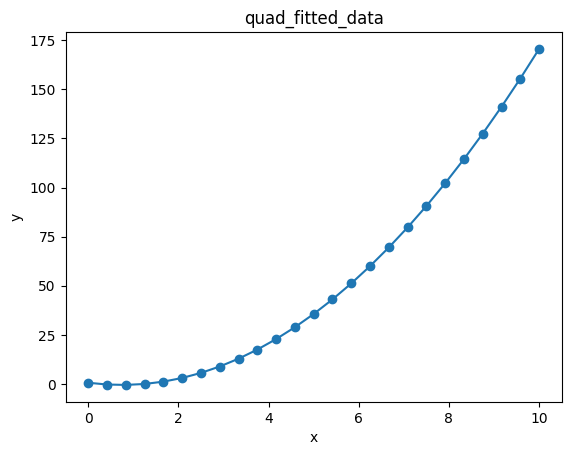

In [134]:
x_data = np.linspace(0, 10, 25)
y_data = 2 * x_data**2 - 3 * x_data + 1 + np.random.normal(0, 1, len(x_data))
almost_quad_data = DataContainer(list[float](x_data), list[float](y_data))

# Lösung hier einfügen
#   1. Quadratischen Fit berechnen & Parameter ausgeben (Hinweis, da die Daten zufällig verändert werden kann es sein, dass die Parameter nicht exakt stimmen)
#   2. RMSE von den Daten und dem Fit berechnen & ausgeben
#   3. Daten und Fit plotten

quad_fit = PolynomialFitProcessor(2)
rmse_proc = RMSEProcessor()
quad_fitted_data = quad_fit.process(almost_quad_data)
rmse_proc.process(quad_fitted_data, almost_quad_data)
print(quad_fit.get_parameter())
print(rmse_proc.get_parameter())

almost_quad_data.plot()
quad_fitted_data.plot()